# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
from scipy.stats import ks_2samp
import pickle

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

####  Explore Structure of Dataframes

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.shape

(891221, 85)

In [7]:
azdias.dtypes

AGER_TYP                   int64
ALTERSKATEGORIE_GROB       int64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GEBURTSJAHR                int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP                 int64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ           int64
PRAEGENDE_JUGENDJAHRE      int64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
          

In [8]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [9]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,TITEL_KZ,person,ordinal,[-1]
freq,1,43,49,26


In [10]:
feat_info.shape

(85, 4)

In [11]:
feat_info.dtypes

attribute             object
information_level     object
type                  object
missing_or_unknown    object
dtype: object

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# list out unique missing names
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [13]:
def isint(value):
    """
    check if value can be made an integer
    """
    try:
        int(value)
        return True
    except ValueError:
        return False

In [14]:
def makeint(some_list):
    """
    Iterates over items and makes them int if possible
    """
    
    for i in range(len(some_list)):
        if isint(some_list[i]):
            some_list[i]=int(some_list[i])
    return some_list

In [15]:
def make_miss_list(df_col):
    '''
    Takes in a dataframe column that has string codes for NaNs
    returns a list that maps the NaN values
    assumes the column ordering will not change
    '''
    
    miss_list=[]
    for entry in df_col: #loop over rows in col
        a=re.findall(r"[-\w']+|[.,!?;]", entry) #separate by punctuation
        a=[x for x in a if x!=','] #drop commas
        miss_list.append(a)
    
    for value in miss_list:
        value=makeint(value)
    
    return miss_list

In [16]:
#get the list of missing columns
miss_list= make_miss_list(feat_info['missing_or_unknown'])
miss_list[0:10]

[[-1, 0], [-1, 0, 9], [-1, 0], [0], [-1], [-1], [-1], [-1], [-1], [-1]]

In [17]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [18]:
#copy to new dataframe
azdias_nan=azdias.copy()

for column, nan_code in zip(azdias_nan.columns, miss_list):
    if nan_code: #skip for empty arrays
        #replace with np.nan
        azdias_nan[column]=azdias_nan[column].replace(to_replace=nan_code, value=np.nan, inplace=False)
#dispaly head
azdias_nan.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

#### Investigate patterns in the amount of missing data in each column
<br>

In [19]:
def nan_count(df, axis=0, std_lim=1.5, display=True):
    """
    counts NaNs in a dataframe along a given axis
    returns number of NaNs by axis element and cutoff
    """
    #count of nan by axis
    nan_count=df.isna().sum(axis=axis).tolist();
    #display as percentage of rows
    nan_count=np.divide(nan_count, df.shape[axis])
    #determine cutoff for NaN
    cutoff=std_lim*np.std(nan_count)
    nan_mean=np.mean(nan_count)
    
    if axis==0:
        ax='column'
    elif axis==1:
        ax='row'
    else:
        pass
    if display:
        print("On average each {} has {:.0%} nan values and cutoff at {} times \
the standard deviaiton is {:.0%}".format(ax, nan_mean, std_lim, cutoff))
    
    return nan_count, cutoff

In [20]:
nan_count_col, cutoff= nan_count(azdias_nan, axis=0, std_lim=1.5)

On average each column has 11% nan values and cutoff at 1.5 times the standard deviaiton is 25%


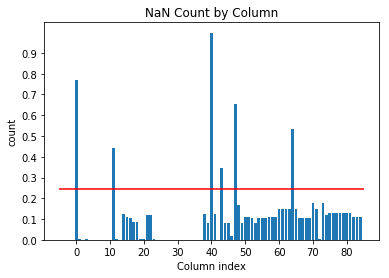

<Figure size 432x432 with 0 Axes>

In [21]:
plt.bar(np.arange(0,len(nan_count_col)), nan_count_col)
plt.title("NaN Count by Column")
plt.xlabel('Column index')
plt.ylabel("count")
plt.yticks(np.arange(0,1, 0.1))
plt.xticks(np.arange(0, azdias_nan.shape[1], 10))
plt.hlines(y=cutoff, xmin=-5,xmax=azdias_nan.shape[1], colors='red')
plt.figure(figsize=(6,6))
plt.savefig("nan_count_column.png")
plt.show()

In [22]:
#get column names with more than cutoff nan
column_nan= [ j for (i,j) in zip(nan_count_col,azdias_nan.columns) if i >= cutoff ]
column_nan

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

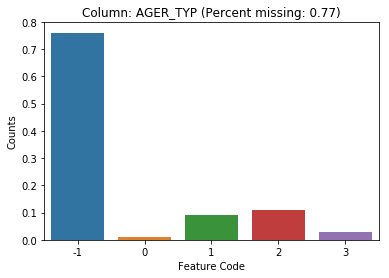

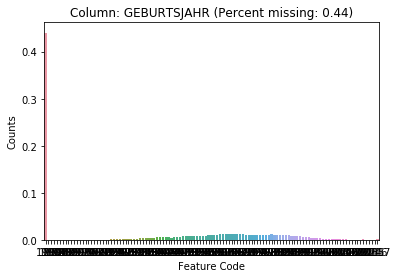

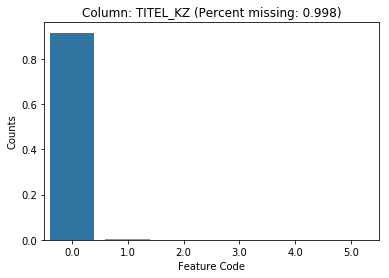

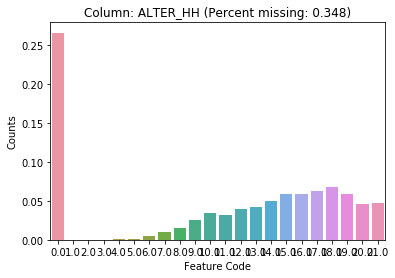

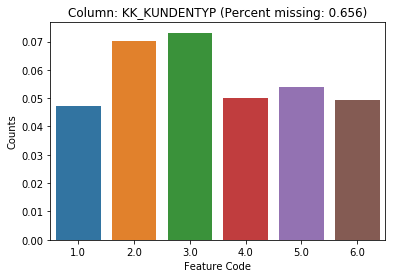

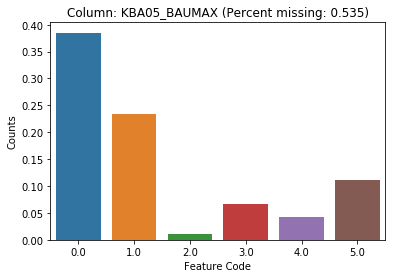

In [23]:
for col in column_nan:
    i= np.round(azdias.columns.get_loc(col), 2)
    i=np.round(nan_count_col[i], 3)
    i=str(i)
    counts=azdias[col].value_counts()
    counts=np.divide(counts, azdias.shape[0])
    sns.barplot(counts.index, counts.values)
    plt.title("Column: "+ col +" (Percent missing: "+ i +')')
    plt.ylabel('Counts')
    plt.xlabel("Feature Code")
    plt.savefig('plots/'+col+'.png')
    plt.show()

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_drop= azdias_nan.drop(labels=column_nan, axis=1)
azdias_drop.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column


How many NaN values can we tolerate in a column before we consider dropping it? Is the threshold 10%? 20%? 80%? The answer is of course relative, since on average we have ~11% missing values by feature. In addition, we can't infer a distribution for the missing values since they appear to be independent of each other. For the most part, the missing values appear to be features relating to characteristics at the person-level.<br>
For this case we go by a rule of thumb: If it has more NaN values than 1.5 times the standard deviation then drop it. Let us go over each outlier and see what feature it represents.<br>

- AGER_TYP: Best-ager typology<br>
    This is a personal level feature and for the vast  majority it is unkown. The feature appears to be applicable only to elderly persons.
- GEBURTSJAHR: Year of birth<br>
     We do not know the year of birth for more than 40% of the observed sample population.
- TITEL_KZ: Academic title flag<br>
    More than 80% have unknown titles. The other titles are quite rare to obtain and correspond to a very specific subset of the population. As an anecdote, [Germans appear to be obsessed with fancy titles](https://welcometogermerica.com/2015/07/germanys-obsession-with-titles.html).
- ALTER_HH: Birthdate of head of household<br>
    Is the date of birth of the head of household easy to obtain? It is a relevant feature since it can insinuate household income, however it has too many missing values for our cutoff.
- KK_KUNDENTYP: Consumer pattern over past 12 months<br>
    This is a very useful feature since it relates to consumption. However the original dataset already contains a lot of NaN values, somehting we do not see in the barplot.
    
- KBA05_BAUMAX: Most common building type within the microcell<br>
    The building type may be indicative of how residential a neighborhood is, however it contains too many NaNs.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [25]:
azdias_drop.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [26]:
row_nan, cutoff_row= nan_count(azdias_drop, axis=1, std_lim=3)

On average each row has 7% nan values and cutoff at 3 times the standard deviaiton is 50%


In [27]:
#get row ids with more than cutoff nan
row_nan_id= [ j for (i,j) in zip(row_nan,range(azdias_drop.shape[0])) if i >= cutoff_row ]
len(row_nan_id)

74113

In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#df with no nans
azdias_row_nonan=azdias_drop.iloc[~azdias_drop.index.isin(row_nan_id), :]
print(azdias_row_nonan.shape)

#df of what is left
#azdias_row_nan=azdias_nan.iloc[row_nan_id,:]

#print(azdias_row_nan.shape)

(817108, 79)


In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#columns with no nans
column_full= [ j for (i,j) in zip(nan_count_col,azdias_nan.columns) if i <= 0.0 ]
#rows with no nans
row_full= [ j for (i,j) in zip(row_nan,range(azdias_drop.shape[0])) if i <= 0.0 ]

In [30]:
#select rows and columns with no nans
azdias_full=azdias_nan.loc[row_full, column_full]
#new shape
azdias_full.shape

(623209, 24)

In [31]:
#check for nans in columns
azdias_full_nan_count= (len(azdias_full)-azdias_full.count()).tolist()
#assertion that no nans are present
for value in azdias_full_nan_count:
    assert value==0

In [32]:
def countview(df, n=10 , display=False):
    """
    Takes in a dataframe and produces countplots for NaN and non-Nan values based on rows
    """
 
    #get nans in rows
    nan_row, cutoff_row = nan_count(df=df, axis=1, std_lim=1.5, display=False);
    #get row ids with less than cutoff nan
    row_full= [ j for (i,j) in zip(nan_row,range(df.shape[0])) if i <= cutoff_row ]
    
    #select dataframe that makes the cut
    df_full=df.loc[row_full,:]
    
    #dump everything else in other dataframe
    df_nan=df.iloc[~df.index.isin(row_full), :]

    #pick n columns to compare in distributions
    df_full_sample=df_full.sample(axis=1,n=n)
    
    #pick the same columns in df_nan
    df_nan_sample=df_nan.loc[:, df_full_sample.columns]
    #drop the columns if entirely made up of NaNs
    df_nan_sample=df_nan_sample.dropna(axis=1, how='all')
    
    #update n
    if df_nan_sample.shape[1] <n:
        print("Dropping {} NaN columns...".format(n-df_nan_sample.shape[1]))
        n=df_nan_sample.shape[1]
        

    
    fig, ax = plt.subplots(n,2, figsize=(20,20))
    fig.subplots_adjust(wspace=0.2, hspace=0.7)
    #fig.tight_layout()
    
    for row, col in  zip(range(n) ,df_nan_sample.columns):
        sns.countplot(x=col, data=df_full_sample, ax=ax[row, 0]).set_title(col+ ' NaNs Removed')
        sns.countplot(x=col, data=df_nan_sample, ax=ax[row, 1]).set_title(col + ' NaNs Included')            

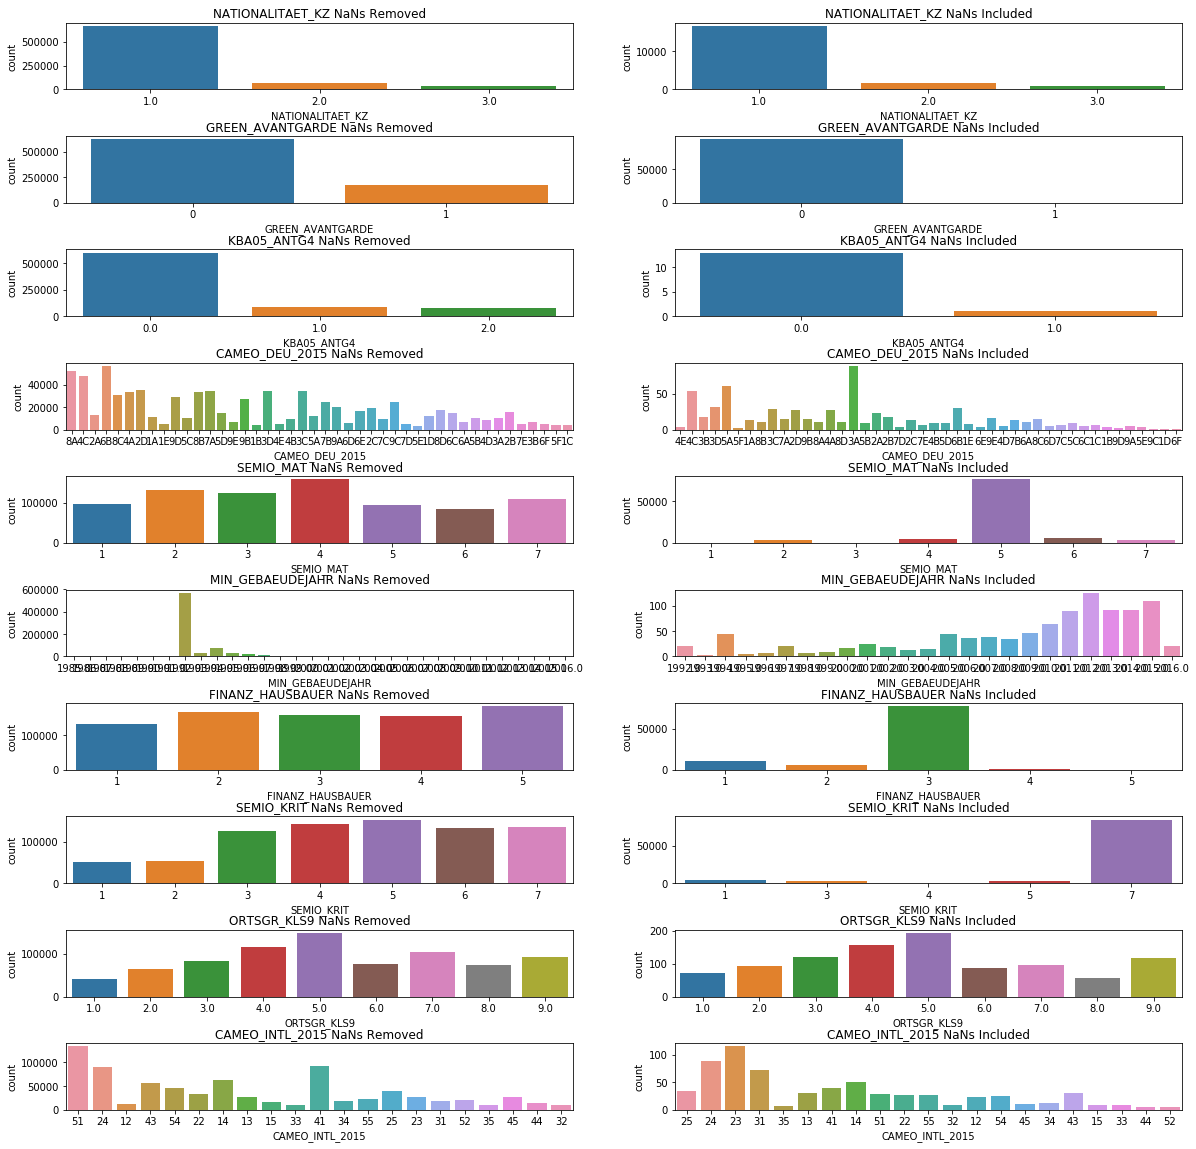

In [33]:
countview(azdias_drop)

#### Discussion 1.1.3: Assess Missing Data in Each Row

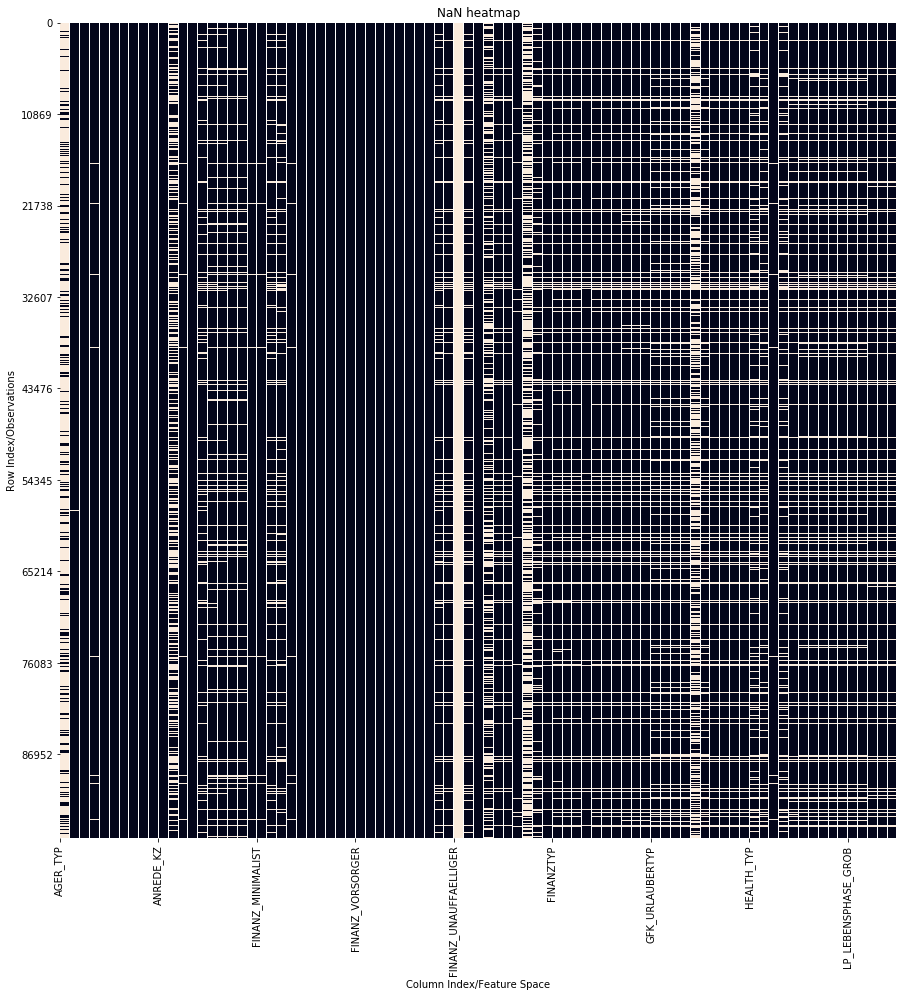

In [34]:
### uncomment block to see heatmap, takes a a while to generate ###


plt.figure(figsize=(15,15))
sns.heatmap(azdias_nan.isnull(), cbar=False)
plt.title("NaN heatmap")
plt.xticks(np.arange(0, azdias_nan.shape[1], 10))
plt.yticks(np.arange(0, azdias_nan.shape[0], 100000))
plt.xlabel("Column Index/Feature Space")
plt.ylabel("Row Index/Observations")
plt.savefig("plots/nan_heat.png")

plt.show()

The plot above show the distribution of NaN values across the dataframe as a heatmap. White lines correspond to blank entries. The plots in the previous section show the distribution of observations for  randomly sampled features between two dataframes. We divide a dataframe into two parts based on the amount of NaNs in the rows. Anything beyond an arbitrary NaN cutoff value per rows is relegated to a second dataframe. In this way we are applying a sieve on our data and answer the question: How would our data look like if we excluded some observations for missing data?. Note that in some cases, more than one column might be made entirely of NaNs. This means that for a whole subset of the population, we do not have observations for a feature.<br>

We can clearly see that the distribution of the data clearly varies between some features. In addition, some observations are entirely missing between the two dataframes. The next section takes a deeper look into this disparity using a statistical approach.

#### Kolmogorov–Smirnov test 

In [35]:
#consider a dataframe that is what was left after removing nans from some rows
#note to keep the full feature space
azdias_empty=azdias_drop.iloc[azdias_drop.index.isin(row_nan_id), :]

# consider the Kolmogorov–Smirnov test
#single out the columns from the main dataset
comp_df=pd.DataFrame(azdias_drop.columns, columns=['col'])

In [36]:
def hypothesis_test(df1, df2, cols):
    
    """
    This tests whether 2 samples are drawn from the same distribution.
    Note that, like in the case of the one-sample K-S test, the distribution is assumed to be continuous.
    """
    
    stats = [] #KS statistic
    pvalues = [] #pvalues
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

In [37]:
#perform hyptothesis test
stats, pvalues= hypothesis_test(azdias_row_nonan, azdias_empty, azdias_empty.columns.values)
#create columns for stast
comp_df['stats'] = stats
comp_df['pvalues'] = pvalues

#store significance as 1 for significant and 0 for not
significant=[]
for val in pvalues:
    if val<0.05:
        significant.append(1)
    else:
        significant.append(0)

comp_df['significant']=significant
comp_df.head()

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4775: RuntimeWarning: invalid value encountered in true_divide
  cdf2 = np.searchsorted(data2, data_all, side='right') / (1.0*n2)
/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4780: RuntimeWarning: divide by zero encountered in double_scalars
  prob = distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)


,col,stats,pvalues,significant
0,ALTERSKATEGORIE_GROB,1.0,0.011066,1
1,ANREDE_KZ,1.0,0.097027,0
2,CJT_GESAMTTYP,1.0,0.001300,1
3,FINANZ_MINIMALIST,1.0,0.003781,1
4,FINANZ_SPARER,1.0,0.003781,1


In [38]:
plt.figure(figsize=(100,200))
for i, col in enumerate(azdias_drop.columns[:10]):
    plt.subplot(5, 2, i+1)
    sns.distplot(azdias_row_nonan[col][azdias_row_nonan[col].notnull()], label='azdias_row_nonan')
    sns.distplot(azdias_empty[col][azdias_empty[col].notnull()], label='azdias_empty')
    plt.title('Distribution for column: {}'.format(col), fontsize=100)
    plt.legend(fontsize=60);
    
plt.savefig('plots/smirnov.png')

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [39]:
comp_df['significant'].value_counts()

0    41
1    38
Name: significant, dtype: int64

The lower the p value the more we can be confident that the two distributions are diffenet. As we can see from the plots above, the distributions vary significantly between the cleaned dataset and omitted rows for some features. This leads us to say that there is some information loss during the cleaning. <br>
At some point we might revisit this data and see if it holds additional meaning.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [40]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [41]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [42]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categoricals=feat_info['attribute'][feat_info['type']=='categorical'].tolist()
#keep categoricals of interest
categoricals=[cat for cat in categoricals if cat in azdias_row_nonan]
categoricals

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [43]:
#opt for pandas.get_dummies because of NaNs
azdias_dum = azdias_row_nonan.copy()

In [44]:
# Re-encode categorical variable(s) to be kept in the analysis.
to_drop=[]

for cat in categoricals:
    if azdias_nan[cat].dtypes=='O': #encore if string
        temp=pd.get_dummies(azdias_nan[cat], prefix=cat) #get the dummies in temporary dataframe
        azdias_dum=pd.concat([azdias_dum, temp], axis=1) #append to right
        to_drop.append(cat) #keep track of dummies
        
    elif azdias_nan[cat].value_counts().shape[0]>2: #encode if non binary
        temp=pd.get_dummies(azdias_nan[cat], prefix=cat)
        azdias_dum=pd.concat([azdias_dum, temp], axis=1)
        to_drop.append(cat)
    else:
        print('{} is binary categorical with numerical values'.format(cat))

#drop the columns after one hot
azdias_dum=azdias_dum.drop(labels=to_drop, axis=1)
azdias_dum.shape

ANREDE_KZ is binary categorical with numerical values
GREEN_AVANTGARDE is binary categorical with numerical values
SOHO_KZ is binary categorical with numerical values
VERS_TYP is binary categorical with numerical values


(891221, 195)

In [45]:
azdias_dum.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

The first choice is panda's get_dummies method over sklearn's one hot encode. The reason being that sklearn returns an error when encountering NaNs. Dropping all NaNs from the data will yield signficant information loss and we wish to avoid that situation.<br>
For categorical features we opt to one hot encode if one of the conditions below is satisfied:
- The feature is as an object, i.e a non scalar
- The feature is numerical but not binary

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
mixed=feat_info['attribute'][feat_info['type']=='mixed'].tolist()
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

#### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west):
- Decade
- Movement

In [47]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_dum['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188663
8.0     145941
5.0      86403
10.0     85808
3.0      55189
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21281
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [48]:
jugend_era_dict={'40': [1, 2],
              '50': [3,4],
              '60': [5,6,7],
              '70': [8,9],
              '80': [10,11,12,13],
              '90': [14,15]}


[Return first matching key in dict for a value](https://stackoverflow.com/questions/16588328/return-key-by-value-in-dictionary)

In [49]:
#helped function for mapping
def find_key(input_dict, value):
    return next((k for k, v in input_dict.items() if value in v), np.nan)

In [50]:
#find the era for each
jugend_era=[]
for val in azdias_dum['PRAEGENDE_JUGENDJAHRE']:
    jugend_era.append(find_key(jugend_era_dict, val))
    
len(jugend_era)

891221

In [51]:
jugend_mov=[]
for val in azdias_dum['PRAEGENDE_JUGENDJAHRE']:
    if val in [1,3,5,8,10,12,13,15]:
        jugend_mov.append(1)
    elif val in [2,4,6,7,9,11,14]:
        jugend_mov.append(0)
    else:
        jugend_mov.append(np.nan)


#### CAMEO_INTL_2015


In [52]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_dum['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [53]:
def str_to_int(col, pos=0):
    '''
    input: array
    returns: values as integer if possible as a list
    '''
    #container
    number_list=[]
    
    for value in col:
        if pd.isna(value):
        #filter out nans before attempting to make int
            number_list.append(value)
        else:
            value=int(value[pos])
        #append to cameo as
            number_list.append(value)
    return number_list
    

In [54]:
cameo_wealth=str_to_int(azdias_dum['CAMEO_INTL_2015'], 0)
cameo_stage=str_to_int(azdias_dum['CAMEO_INTL_2015'], 1)

In [55]:
#rural or not rural
rural=[]
for val in azdias_dum['WOHNLAGE']:
    if val>5:
        rural.append(1)
    else:
        rural.append(0)

#### Discussion 1.2.2: Engineer Mixed-Type Features
For **PRAEGENDE_JUGENDJAHRE** we engineer two variables: era and dominating policitcal povement. The political movement is binary numerical between avant garde and mainsteam. For the era we encode it as categorical feature and then one hot encode it.<br>
For the wealth and life stage from **CAMEO_INTL_2015**, the observation is encoded as an integer stored as a string. We opt to slice the string in tens and ones, and convert the result into an integer. <br>
For both cases the trick is detecting and dealing with NaN values. In theory we could drop all NaNs from the dataframe but as said before, that would severly reduce our dataset. An interesting find while setting up the encoding is that [NaN==NaN returns false](https://stackoverflow.com/questions/1565164/what-is-the-rationale-for-all-comparisons-returning-false-for-ieee754-nan-values/1573715#1573715), and the [difference between panda's isna() and isnull()](https://datascience.stackexchange.com/questions/37878/difference-between-isna-and-isnull-in-pandas). <br>
The features **LP_LEBENSPHASE_FEIN** and **LP_LEBENSPHASE_GROB** are both numeric although they are classified as mixed. The features are already fine enough as is and we keep them unchanged.<br>
**WOHNLAGE** can indicate of the neighborhood is rural or not. We draw on the description in the data dictionary to define a binary feature: rural or not rural.<br>
For **PLZ8_BAUMAX** the scale is ordinal from 1-4 with size of housing buildings,  5 indicates business buildings. Let us assume that 10+ family homes are akin to a business building density. The same analogy applies to **KBA05_BAUMAX**. The better option is to keep these two features as is. Indeed, if we dummy encode them than we are losing the ordinal component. On the other hand we must keep in mind that they might not be evenly spaced, that is to say a business buildings area might be 5 times denser than a family home. Regardless, we keep them as is and make the simplifying assumptio that they are on an evenly spaced scale.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [56]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#instantiate copy of dataframe
azdias_cat=azdias_dum.copy()
#drop columns
#drop OST_WEST_KZ_W since OST_WEST_KZ_O is sufficient
azdias_cat=azdias_cat.drop(columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'OST_WEST_KZ_W', 'WOHNLAGE'])
#append the binary political movement feature
azdias_cat['politic']=jugend_mov
#append wealth
azdias_cat['wealth']=cameo_wealth
#append life stage
azdias_cat['stage']=cameo_stage
#append era
azdias_cat['era']=jugend_era
#append rural or not
azdias_cat['rural']=rural

In [57]:
azdias_cat.shape

(891221, 196)

In [58]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

interval=feat_info['attribute'][feat_info['type']=='interval'].tolist()
interval

['ALTER_HH']

**ALTER_HH** refers to Birthdate of head of household. The intervals are refered to by integer values and we opt to keep it as is.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [59]:
def clean_data(df, df_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    Assumes certain column names are present and properties about dataframe
    
    INPUT:
    - Demographics DataFrame
    - mapping for NaNs
    - std tolerance for nan rows
    - list of categorical column names
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    
    #get the list of missing columns
    miss_list= make_miss_list(feat_info['missing_or_unknown'])
    
    #copy to new dataframe
    df_nan=df.copy()

    for column, nan_code in zip(df_nan.columns, miss_list):
        if nan_code: #skip for empty arrays
            #replace with np.nan
            df_nan[column]=df_nan[column].replace(to_replace=nan_code, value=np.nan, inplace=False)
            
    #columns to drop
    column_nan=['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    df_drop= df_nan.drop(labels=column_nan, axis=1)


    #get row nans
    row_nan, cutoff_row= nan_count(df_drop, axis=1, std_lim=3)
    #set arbitrary limit for NaN percentage
    
    
    #get row ids with more than cutoff nan
    row_nan_id= [ j for (i,j) in zip(row_nan,range(df_drop.shape[0])) if i >= cutoff_row ]
    
    #df with no nans in row beyond limit
    df_row_nonan= df_drop.copy()
    df_row_nonan=df_row_nonan.iloc[~df_drop.index.isin(row_nan_id), :]
    
    #get categoricals
    #categoricals=feat_info['attribute'][feat_info['type']=='categorical'].tolist()
    #keep columns that were not dropped
    #categoricals= [cat for cat in categoricals if cat in df_drop.columns]
    
    categoricals= ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
                   'LP_FAMILIE_FEIN','LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                   'NATIONALITAET_KZ','SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP','ZABEOTYP',
                   'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    
    
    #opt for pandas.get_dummies because of NaNs
    df_dum = df_row_nonan.copy()
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    to_drop=[]

    for cat in categoricals:
        if df_dum[cat].dtypes=='O': #encore if string
            temp=pd.get_dummies(df_dum[cat], prefix=cat) #get the dummies in temporary dataframe
            df_dum=pd.concat([df_dum, temp], axis=1) #append to right
            to_drop.append(cat) #keep track of dummies
        
        elif df_dum[cat].value_counts().shape[0]>2: #encode if non binary
            temp=pd.get_dummies(df_dum[cat], prefix=cat)
            df_dum=pd.concat([df_dum, temp], axis=1)
            to_drop.append(cat)
        else:
            print('{} is binary categorical with numerical values'.format(cat))

    #drop the columns after one hot
    df_dum=df_dum.drop(labels=to_drop, axis=1)
    
    jugend_era_dict={'40': [1, 2],
              '50': [3,4],
              '60': [5,6,7],
              '70': [8,9],
              '80': [10,11,12,13],
              '90': [14,15]}
    
    #find the era for each
    jugend_era=[]
    for val in df_dum['PRAEGENDE_JUGENDJAHRE']:
        jugend_era.append(find_key(jugend_era_dict, val))
        
    jugend_mov=[]
    for val in df_dum['PRAEGENDE_JUGENDJAHRE']:
        if val in [1,3,5,8,10,12,13,15]:
            jugend_mov.append(1)
        elif val in [2,4,6,7,9,11,14]:
            jugend_mov.append(0)
        else:
            jugend_mov.append(np.nan)

    
    cameo_wealth=str_to_int(df_dum['CAMEO_INTL_2015'], 0)
    cameo_stage=str_to_int(df_dum['CAMEO_INTL_2015'], 1)
    
    #rural or not rural
    rural=[]
    for val in df_dum['WOHNLAGE']:
        if val>5:
            rural.append(1)
        else:
            rural.append(0)

    
    
    #instantiate copy of dataframe
    df_cat=df_dum.copy()
    #drop columns
    #drop OST_WEST_KZ_W since OST_WEST_KZ_O is sufficient
    df_cat=df_cat.drop(columns=['PRAEGENDE_JUGENDJAHRE',
                                        'CAMEO_INTL_2015', 'OST_WEST_KZ_W', 'WOHNLAGE'])
    #append the binary political movement feature
    df_cat['politic']=jugend_mov
    #append wealth
    df_cat['wealth']=cameo_wealth
    #append life stage
    df_cat['stage']=cameo_stage
    #append era
    df_cat['era']=jugend_era
    #append rural or not
    df_cat['rural']=rural
    
    
    # Return the cleaned dataframe.
    return df_cat
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [60]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_clean= clean_data(azdias, feat_info)
#evaluate final shape
print("Shape after cleaning: {}".format(azdias_clean.shape))

On average each row has 7% nan values and cutoff at 3 times the standard deviaiton is 50%
ANREDE_KZ is binary categorical with numerical values
GREEN_AVANTGARDE is binary categorical with numerical values
SOHO_KZ is binary categorical with numerical values
VERS_TYP is binary categorical with numerical values
Shape after cleaning: (817108, 196)


In [61]:
#instantiate imputer
imputer = Imputer(missing_values=np.NaN, strategy='median', axis=0)
#fit to the dataset
imputer.fit(azdias_clean)

Imputer(axis=0, copy=True, missing_values=nan, strategy='median', verbose=0)

In [62]:
#transform the dataset by filling NaN values
azdias_median= imputer.transform(azdias_clean)

In [63]:
# Apply feature scaling to the general population demographics data.
scaler=MinMaxScaler()
scaler.fit(azdias_median)
azdias_scaled=scaler.transform(azdias_median)

### Discussion 2.1: Apply Feature Scaling

Consider the two types of scaling available: <br>
- [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
- [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

StandardScaler is calculated as **z = (x - u) / s** where u is the mean of the training samples and s is the standard deviation of the training samples. Outliers will have an influence when computing the empirical mean and standard deviation.
<br>

MinMaxScaler estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

<br>
Our choice with the SimpleImputer for fill values is:
- mean
- median
- mode
- constant

<br>

The MinMax scaler is unaffected by the choice of fill, whereas the StandardScaler will be affected unless we replace the NaNs by the mean. Consider also that other techniques handle better data squished between 0 and 1. Consider also that we ignore the distribution of the data, it can be normally distributed or as seen before can be heavily skewed to one value. We opt to fill the missing values with the median of each feature, with the assumption that it will not skew our results.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [64]:
# Apply PCA to the data.
pca_pre= PCA()
pca_pre.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [65]:
# Investigate the variance accounted for by each principal component.
pca_pre.explained_variance_ratio_[:10]

array([0.11167661, 0.08243491, 0.05220174, 0.04636586, 0.03565831,
       0.02405735, 0.0223883 , 0.01983722, 0.01921531, 0.01886575])

In [66]:
#store cumulative sume of explained variance ratio
cumsum=np.cumsum(pca_pre.explained_variance_ratio_)

In [67]:
#find how many components account for 80% of the variance
pca_95= np.argmax(cumsum>0.95)
print(pca_95)

98


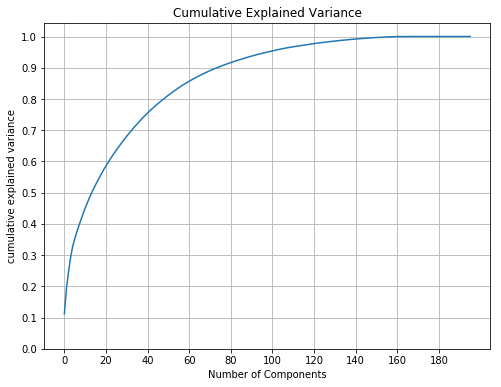

In [68]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca_pre.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance')
plt.xticks(np.arange(0,len(pca_pre.explained_variance_ratio_), 20))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid(b=True)
plt.savefig('plots/pca_cumsum_pre.png')
plt.show()

In [69]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca=PCA(n_components=pca_95)
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=98, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [70]:
azdias_pca=pca.transform(azdias_scaled)

In [71]:
azdias_pca.shape

(817108, 98)

### Discussion 2.2: Perform Dimensionality Reduction

The plot above reveals the cumulative explained variance of each component as a cumulative sum of the ratios. The sum of ratios will naturally equal 1. We also see that beyond a certain point we are facing diminishing returns as the curve levels out. In total we have around 200 features and some can be omitted for a low level representation of the data. We find out that we only need half the amount of features to explain about 95% of the variance.  Therefore we instantiate a new PCA where we keep enough components to account for 95% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [72]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

#index dimensions
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

#PCA componenets
components= pd.DataFrame(np.round(pca.components_, 4), columns=azdias_clean.keys().tolist())
components.index=dimensions
components=components.T

components.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6,Dimension 7,Dimension 8,Dimension 9,Dimension 10,...,Dimension 89,Dimension 90,Dimension 91,Dimension 92,Dimension 93,Dimension 94,Dimension 95,Dimension 96,Dimension 97,Dimension 98
ALTERSKATEGORIE_GROB,-0.0835,0.2212,0.0121,0.0307,-0.0073,0.0183,-0.0335,-0.0207,0.0009,-0.0342,...,0.0445,-0.0291,0.0341,0.1066,0.0439,0.0592,-0.0864,0.0898,-0.0063,0.0022
ANREDE_KZ,0.0265,0.0525,-0.5047,-0.0243,0.0677,-0.0050,0.0489,-0.0546,0.0454,-0.0130,...,-0.0251,0.0996,0.0622,0.0562,0.0140,-0.0172,-0.0141,-0.1041,0.0468,0.0290
FINANZ_MINIMALIST,-0.1932,0.0904,0.1252,0.0075,0.0100,-0.1004,0.0975,-0.0515,0.0178,0.0227,...,0.0393,0.0130,-0.0322,0.0447,0.0176,-0.0483,0.0672,-0.0014,0.0369,-0.0485
FINANZ_SPARER,0.1274,-0.2438,-0.0521,-0.0342,-0.0077,-0.0004,-0.0086,0.0169,-0.0147,-0.0237,...,0.0084,-0.0500,0.0467,0.1257,0.0393,0.0858,-0.1591,-0.0307,-0.0408,-0.0050
FINANZ_VORSORGER,-0.0863,0.2152,0.0363,0.0416,0.0016,0.0077,-0.0933,-0.0082,-0.0565,0.0554,...,-0.0060,0.0984,0.0547,-0.1220,0.0108,-0.0355,0.1521,0.0405,-0.0071,-0.0221


In [73]:
components.shape

(196, 98)

In [ ]:
def comp_weights(components, comp=0, topk=5, saveloc=None):
    #get sorted weights for dimension
    #note that comp 0 corresponds to dimension 1
    
    dim=components.copy()
    dim=dim.iloc[:,comp]
    
    #dim_sort= np.sort(dim)
    dim_sort=dim.sort_values(ascending=True)
    
    #plot the feature weights as a function of the components
    plt.figure(figsize=(20,10))
    plt.bar(x=dim_sort.index, height=dim_sort, tick_label=dim_sort.index)
    plt.xlabel("Features")
    plt.xticks(rotation=90, fontsize=5)
    plt.ylabel("Weights")
    plt.title("Weights of Dimension {}".format(comp+1))
    plt.savefig("plots/expl_var"+str(comp+1)+'.png')
    if saveloc:
        plt.savefig(saveloc)
    
    plt.show()
    
    print("{} most positive weights for the {} component: \n".format(topk, comp+1))
    print(dim_sort[-5:], '\n')
    print("{} most negative weights for the {} component: \n".format(topk, comp+1))
    print(dim_sort[0:5])

In [ ]:
comp_weights(components, 0, saveloc='plots/dim_1.png')

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_weights(components, 1,saveloc='plots/dim_2.png')


In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_weights(components, 2,saveloc='plots/dim_3.png')


### Discussion 2.3: Interpret Principal Components

#### First Principal Component
**LP_STATUS_GROB_1.0** refers the social status on a rough scale. As an indicator of wealth, it is clear why it would be positively correlated with features like **wealth**. **PLZ8_ANTG4** refers to the number of families in the PLZ8 and appears to be the equivalent of zip code in the US. We do not know what that region is but there appears to be a positive correlation between the number of family homes in an area and economic status. Before moving to the next section we should keep in mind that the signs of weights are only importance in relation to the other weights inside the vector.
<br>

On the other hand of the spectrum **FINANZ_MINIMALIST** refers to the financial topology, with higher values indicating a lower topology. We assume that individuals with topologically low financial situations are also low on the economic scale. In addition **KBA05_ANTG1** refers to the share of 1-2 family houses in the microcell. We can infer that affluent regions face less crowding issues, therefore a high share of families sharing the same house indicates lower economic status. Furthermore **KBA05_GBZ** refers to the number of buildings in the microcell. <br>

Overall, individual wealth appears to be negatively correlated with the crowding in the neighborhood.

#### Second Principal Component
**ZABEOTYP_3** is one of our engineered features and corresponds to a fair supplied energy consumption typology. Interestingly enough it is posivtively correlated with **ALTERSKATEGORIE_GROB** which indicates the estimated age based on name analysis. It is also positively correlated with **FINANZ_VORSORGER**, referring to financial tpology. We can see how low econmic status positively correlates to more judicioous energy comsumption.
<br>

On the other end **era_90** is one of our engineered features and negatively correalates to energy consumption.  The era might indicative of a generational habit and less concern about energy consumption.**FINANZ_SPARER** relates to money saving, with high values meaning less money saving. **UNAUFFAELLIGER** relates to conspicuous spending, higher values meaning clearly visible spending.<br>
The second component seems to tie an ecological dimension with energy consumption.

#### Third Principal Component

For the third principal component, we see that the top three positive weights **SEMIO_VERT**,**SEMIO_FAM**, and **SEMIO_KULT** all refer to a personality feature. They are contrasted by the most negative weights for features **ANREDE_KZ** specifying gender, **SEMIO_KAEM** and **SEMIO_DOM** which are personality features as well. This third component seems to tie personality traits that are correlated to each other. We do not what the names mean specifically but we can understand how individuals with one personality trait might abhor another trait. Moreover, it is interesting how gender comes into play with these characeristics. Keep in mind though that gender is treated as a binary feature here and might not capture the complete spectrum.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [78]:
def minik_ssd(df, batch_size=100, K=range(1,30)):
    '''
    Peforms MiniBatchKMeans on dataframe with user specified batch size & range of clusters
    Input:
    - Dataframe
    - Batch size
    - Range of clusters
    Output:
    - Sum of squared distances over range
    
    '''
    #store evolution of ssd
    ssd=[]
    
    #put fancy progress bar on number of clusters
    for k in tqdm(K):
        # intantiate a mini kmeans 
        kmeans_mini=MiniBatchKMeans(n_clusters=k, batch_size=batch_size)
        kmeans_mini.fit(df)
        # compute the average within-cluster distances.
        ssd.append(kmeans_mini.inertia_)
        
    
    return ssd
    

In [79]:
### Uncomment block below to run mini batch kmeans trials###
### Takes a while to run depending on device###

###set range of clusters to check

K=range(1,41)

###get ssd for arbitrary batches
ssd_100=minik_ssd(azdias_pca, batch_size=100, K=K)
ssd_1000=minik_ssd(azdias_pca, batch_size=1000, K=K)
ssd_10000=minik_ssd(azdias_pca, batch_size=10000, K=K)
ssd_20000=minik_ssd(azdias_pca, batch_size=20000, K=K)
ssd_50000=minik_ssd(azdias_pca, batch_size=50000, K=K)





100%|██████████| 40/40 [08:16<00:00, 16.48s/it]


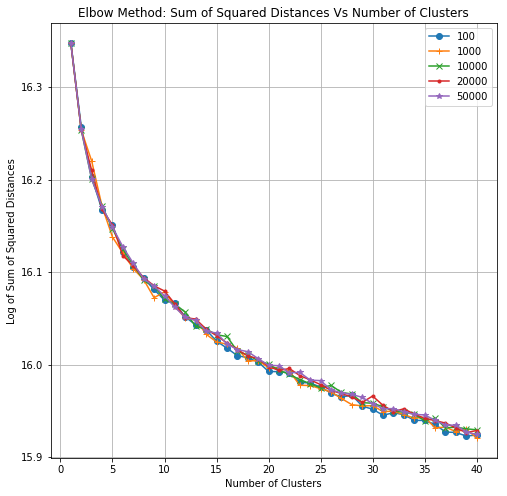

In [80]:
# Investigate the change in within-cluster distance across number of clusters.
# Use matplotlib's plot function to visualize this relationship.


plt.figure(figsize=(8,8))
plt.plot(K, np.log(ssd_100), marker='o') #apply natural log to refuce magnitude
plt.plot(K, np.log(ssd_1000), marker='+')
plt.plot(K, np.log(ssd_10000), marker='x')
plt.plot(K, np.log(ssd_20000), marker='.')
plt.plot(K, np.log(ssd_50000), marker='*')
plt.legend(['100', '1000', '10000', '20000', '50000'], loc='upper right')
plt.xlabel('Number of Clusters')
plt.ylabel('Log of Sum of Squared Distances')
plt.title('Elbow Method: Sum of Squared Distances Vs Number of Clusters')
plt.grid(b=True)
plt.savefig('plots/elbow_minik.png')
plt.show()

In [81]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
best_k=18

kmeans=KMeans(n_clusters=best_k)
kmeans.fit(azdias_pca)


with open('checkpoints/kmeans.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(kmeans, f, pickle.HIGHEST_PROTOCOL)

### Discussion 3.1: Apply Clustering to General Population
For the KMeans algorithm we must take into account time complexity. We can source [Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering#Complexity) and this post on [stack exchange](https://stats.stackexchange.com/questions/183197/k-means-algorithm-for-big-data-analytics) on KMeans time compelxity to deduce that it is **O(tkn)** where:
- n is the number of objects
- k is the number of clusters
- t is how many iterations it takes to converge.

Our dataset is large enough so that we resort to [MiniBatchKMeans](https://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans). Mini batches are a subset of the data, randomly sampled at each training iteration. The documentation suggests that mini batches produces results that are generally slightly worse than the standard algorithm.<br>

In order to determine the appropirate number of clusters, we rely on KMean's **inertia_** attribute: the sum of square distances of samples to their nearest neighbor. The more clusters we have, the smaller our inertia. As the number of clusters reaches the number of observations it tends to near zero, at which point each observation is its own cluster. At a certain number of clusters the inertia will reach an inflection point, preferably a sharp one, where we can clearly see the number of clusters.

We perform MiniBatchKMeans on several batch sizes over the same range of clusters. Unfortunately we don't see the sharp elbow, we might even infer that there are no 'real' clusters in our results. but we can visually determine a point of diminishing returns as the number of clusters grows.<br>

In order to better understand the plot above, we must look into the algorithm and its inherent weaknesses. KMeans clusters are defined by their respective centers, which means that each cluster is a convex shape. KMeans also assumes that all clusters have the same diameter and all directions are equally important for each cluster: the boundary between clusters is exactlty in the middle between cluster centers. We know that the algorithm performs poorly with more complex shapes (half moons for example). <br>

The method has clear drawbacks and we make the judgmene to set the number of clusters to **n_clusters=18** based o the graph above. A further study might want to consider different algorithms for clustering such as [Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) and  [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).  [Gaussian Mixture Models](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) (GMM) are also a viable alternative to KMeans. GMM are slower since they have to incoporate information about the distribution of the data: it has to deal with the covariance, mean, variance, and prior probabilities of the data. In addition GMM have to assign probabilities to belonging to each cluster. Thus in contrast to KMean's hard clustering, GMM gets a lot more structural information and allows to measure how wide each cluster is since we are dealing with probabilities.


<br>

Furthermore to evaluate the number of clusters, we can use the [Silouhette Score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) instead of SSD. The silhouette coefficient is calcualted using the mean intra-cluster distance (a) and the mean nearest cluster distance (b) for each sample. (b) here refers to the dsitance between a sample ad the nereast cluster that the sample is not a part of. The silhouette coefficient for a sample is defined as **(b-a)/max(a,b)**. Note that silhouette coefficient is only defined if the number of labrls is 2 <= n_labels <= n_samples-1.

### Visualize Clustering

In [82]:
#reduce data to 2 components
reduced_data=PCA(n_components=2).fit_transform(azdias_scaled)
clusters=KMeans(n_clusters=best_k, random_state=42).fit(reduced_data)

In [83]:
#set up meshgrid space
x_min = reduced_data[:, 0].min() -1
x_max = reduced_data[:, 0].max() +1
y_min = reduced_data[:, 1].min() - 1
y_max = reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.

xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

In [84]:
#set up predictions and centroids
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])
centroids = clusters.cluster_centers_

In [85]:
def PCA_plot(Z, centroids, saveloc=None):
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(20, 10))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2, alpha=0.08)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    
    if saveloc:
        plt.savefig(saveloc)
    
    plt.show()



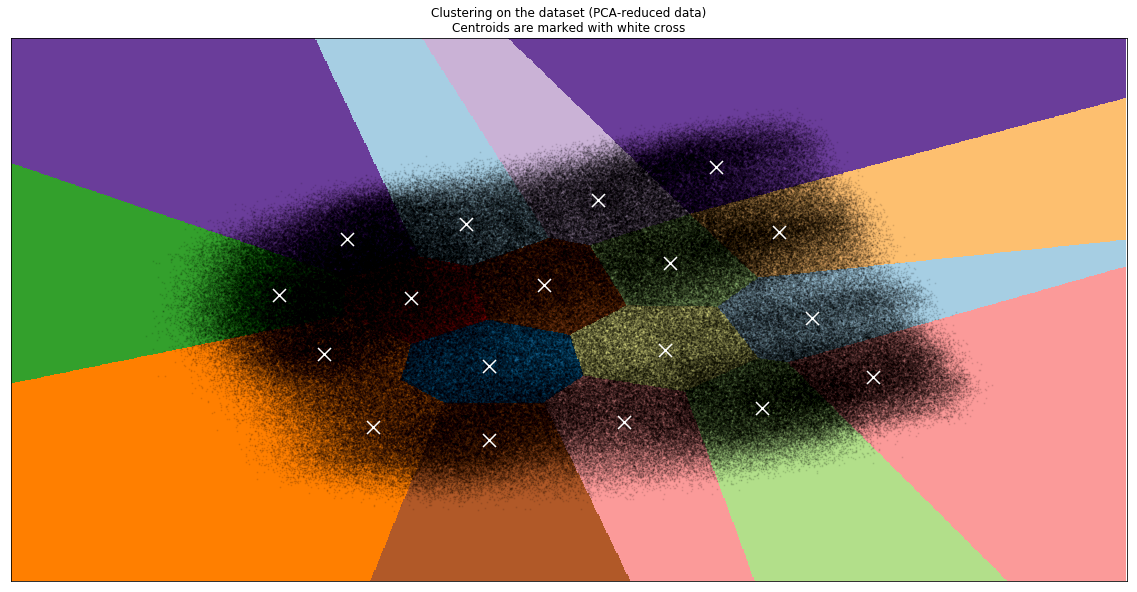

In [86]:
PCA_plot(Z, centroids, 'plots/pca_space.png')

The Plot above shows the feature spaced reduced to a 2 dimentional space. The white crosses mark the location of the centroids after clustering using our guess for numbero f clusters. We can see that the space is not made of distincinct circular blobs, and the boundaries are not clear cut.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [87]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [88]:
customers.shape

(191652, 85)

In [92]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#Perform feature trimming, re-encoding, and engineering for demographics data
customers_clean=clean_data(customers, feat_info)
customers_clean.shape

On average each row has 16% nan values and cutoff at 3 times the standard deviaiton is 75%
ANREDE_KZ is binary categorical with numerical values
GREEN_AVANTGARDE is binary categorical with numerical values
SOHO_KZ is binary categorical with numerical values
VERS_TYP is binary categorical with numerical values


(191652, 195)

In [103]:
#get location of dummies that are missing in customers
insert_loc= customers_clean.columns.get_loc('GEBAEUDETYP_4.0') +1
insert_loc

134

In [105]:
# insert at location where missing
customers_clean.insert(insert_loc, 'GEBAEUDETYP_5.0', 0)

In [106]:
customers_clean.shape

(191652, 196)

In [107]:
#apply imputer
customers_median= imputer.transform(customers_clean)

In [108]:
# Apply feature scaling to the customers data.
#use same scaler for general population applied to customers
customers_scaled=scaler.transform(customers_median)

In [109]:
#use PCA from general pop to transform customers
customers_pca=pca.transform(customers_scaled)
customers_pca.shape

(191652, 98)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [110]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_predict=kmeans.predict(azdias_pca)
customers_predict=kmeans.predict(customers_pca)

In [111]:
#get frequency of cluster counts for general pop
azdias_freq=np.bincount(azdias_predict)/len(azdias_predict)

#get frequency of clusters for customers
customers_freq=np.bincount(customers_predict)/len(customers_predict)

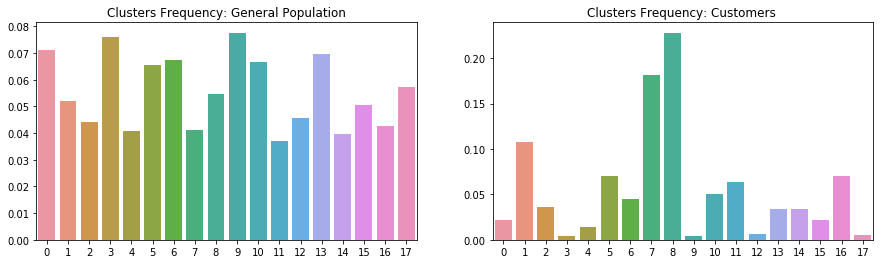

In [112]:
#subplot for side to side
fig, ax = plt.subplots(1,2, figsize=(15,4))

#
sns.barplot(x=np.arange(0,len(azdias_freq)), y=azdias_freq,
            ax=ax[0]).set_title("Clusters Frequency: General Population")

sns.barplot(x=np.arange(0,len(customers_freq)), y=customers_freq,
            ax=ax[1]).set_title("Clusters Frequency: Customers ")

fig.savefig('plots/FrequencyClusters.png')

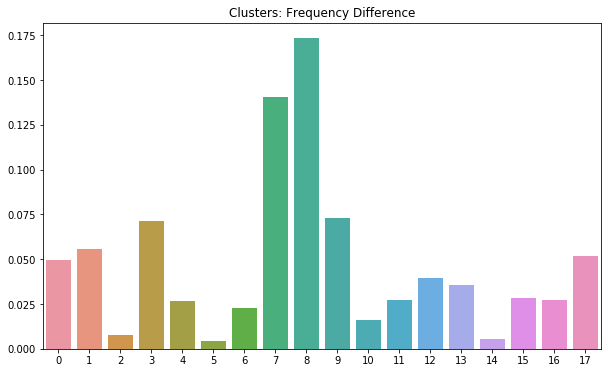

In [113]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#get absolute difference
freq_diff=np.abs(azdias_freq- customers_freq)
plt.figure(figsize=(10,6))
sns.barplot(x=np.arange(0,len(freq_diff)), y=freq_diff).set_title("Clusters: Frequency Difference")
plt.savefig("plots/freq_prct_diff.png")

In [114]:
# get most represented cluster by frequency different
top_cluster=np.argmax(freq_diff)
print("Most represented clsuter: {}".format(top_cluster))
#get least represented cluster by frequency difference
bot_cluster=np.argmin(freq_diff)
print("Least represented clsuter: {}".format(bot_cluster))

Most represented clsuter: 8
Least represented clsuter: 5


In [115]:
def plot_scaled_comaprison(df_sample, kmeans, cluster, pca, saveloc=None):
    #pca inverse transform on clusters
    inv_pca= pca.inverse_transform(kmeans.cluster_centers_[cluster])
    #convert to dict and use columns from full space
    df_dict=dict(zip(df_sample.columns, inv_pca))
    #make dataframe
    df=pd.DataFrame.from_dict(df_dict, orient='index').rename( 
        columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    df['feature_values_abs']=abs(df['feature_values'])
    viz_df= pd.concat((df['feature_values'][:10], df['feature_values'][-10:]), axis=0)
    viz_df.plot(kind='barh')
    if saveloc:
        plt.savefig(saveloc)

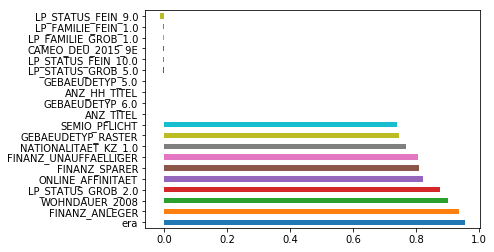

In [116]:
#top cluster
plot_scaled_comaprison(azdias_clean, kmeans, top_cluster, pca, saveloc='plots/top_cluster.png')

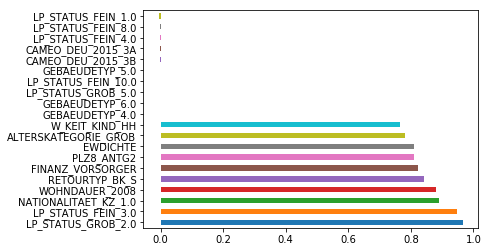

In [117]:
#bottom cluster
plot_scaled_comaprison(azdias_clean, kmeans, bot_cluster, pca,saveloc='plots/bot_cluster.png')

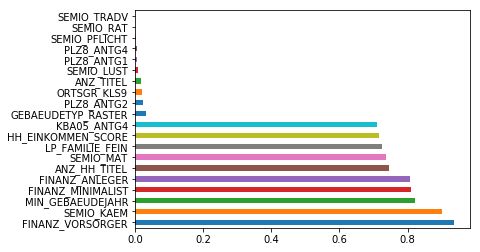

In [118]:
#top cluster on disregarded pop
plot_scaled_comaprison(azdias_empty, kmeans, top_cluster, pca)

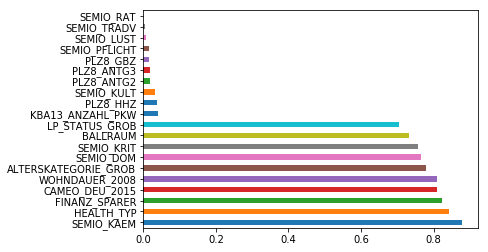

In [119]:
#bottom cluster on disregarded pop
plot_scaled_comaprison(azdias_empty, kmeans, bot_cluster, pca)

### Discussion 3.3: Compare Customer Data to Demographics Data

Cluster 10 is overrepresented in the customer data in comparison to the  general population. These appear to be people who rank high in the era category and thus of the younger crowd. In addition they rank high in the FINANZ_ANLEGER (rough translation: finance investor). Thus this is a crowd that has not spent time thnking in investments. In addition from WOHNDAUER_2008 they have been residing where they are for a while now. Furthermore, the positive weight ONLINE_AFFINITAET shows that customers tend to have a strong internet activity, which is usually expected off people born in the 90s and after.
<br>

For customers not popular with the service, they identify as average earners per the LP_STATUS_GROB feature. In addition, the NATIONALITAET_KZ feature attempts to infer German nationality based on given names. It appears that the service is not popular with people who have 'foreign souding' or 'assimialted' names, that is to say immigrants or descendants of immigrants. We are not sure what SEMIO_ERL means so we skip to LP_STATUS_FEIN, an indicator of social status. It seems that the higher the social class the less likely they are to become customers.
<br>

It is interesting to see gender appear as a positive influence in all categories. Overall, we can infer that the service will be popular with German nationals who are rather young and are freqent internet users. This population can be best reached via online media campaigns. On the other hand, the service is not popular with foreigners and individuals of middle income and higher.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.